# winddy

**这里主要分析正常模型与经过对抗训练的模型的输出的信息熵的差别。***


In [30]:
import torch 
import numpy as np
import os
import torchvision.transforms as transforms
import torchvision
import matplotlib.pyplot as plt
import torch.nn as nn
from LeNet import LeNet
from torch.autograd import Variable

In [31]:
NORMALIZE = True
DEVICE = torch.device('cuda:7' if torch.cuda.is_available() else 'cpu')

In [32]:
if NORMALIZE:
    trans = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
else:
    trans = transforms.Compose([
        transforms.ToTensor(),
    ])

In [33]:
data_home = '/data/winddy/'

train_set = torchvision.datasets.MNIST(root=os.path.join(data_home, 'dataset/MNIST'), train=True, download=True, transform=trans)
test_set = torchvision.datasets.MNIST(root=os.path.join(data_home, 'dataset/MNIST'), train=False, download=True, transform=trans)

In [34]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=True, num_workers=2)

In [35]:
# 可视化数据集
def imshow(img):
    if NORMALIZE:
        img = img * 0.3081 + 0.1307
    np_img = img.numpy()
    plt.imshow(np.transpose(np_img, (1, 2, 0)))
    plt.show()
    
class FGSM:
    def __init__(self, model, criterion, epsilon, device):
        self.model = model
        self.criterion = criterion
        self.epsilon = epsilon
        self.device = device
        assert isinstance(model, torch.nn.Module), "Input parameter model is not nn.Module. Check the model"
        assert isinstance(criterion, torch.nn.Module), "Input parameter criterion is no Loss. Check the criterion"
        assert (0 <= epsilon <= 1), "episilon must be 0 <= epsilon <= 1"
        self.model.eval()


    def __call__(self, input, labels):
        # For calculating gradient
        input_for_gradient = Variable(input, requires_grad=True).to(self.device)
        out = self.model(input_for_gradient)
        loss = self.criterion(out, Variable(labels))

        # Calculate gradient
        loss.backward()

        # Calculate sign of gradient
        signs = torch.sign(input_for_gradient.grad.data)

        # Add
        input_for_gradient.data = input_for_gradient.data + (self.epsilon * signs)

        return input_for_gradient, signs

In [36]:
dataiter = iter(train_loader)
images, labels = dataiter.next()

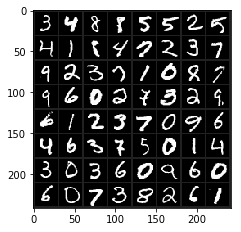

tensor([3, 4, 8, 8, 5, 5, 2, 5, 4, 1, 8, 4, 7, 2, 3, 7, 9, 2, 3, 7, 1, 0, 8, 7,
        9, 6, 0, 2, 7, 3, 2, 9, 6, 1, 2, 3, 7, 0, 9, 6, 4, 6, 3, 7, 5, 0, 1, 4,
        3, 0, 3, 6, 0, 9, 6, 0, 6, 0, 7, 3, 8, 2, 6, 1])


In [37]:
# 可视化部分图片


dataiter = iter(train_loader)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))
print(labels)

# 正常模型：熵

In [38]:

key_info = {'1':'model - clean', '2':'model - advExam', '3': 'modelAdv - clean', '4':'modelAdv - advExam'}
result_info = {}

## 正常模型 - 干净样本

In [39]:
# 读取模型
if NORMALIZE:
    model_path = './model/LeNet_MNIST.pt'
else:
    model_path = './model/LeNet_MNIST_unNormalize.pt'

model = LeNet()
model.load_state_dict(torch.load(model_path))
model = model.to(DEVICE)

In [40]:
# 测试准确率 和 信息熵
model.eval()

test_loss = 0
correct = 0
count = 0

info_arr = torch.tensor([])
info_arr = info_arr.to(DEVICE)
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(DEVICE), target.to(DEVICE)
        output = model(data)
        
        test_loss += torch.nn.functional.cross_entropy(output, target, reduction='sum')
        pred = output.argmax(dim=1, keepdim=True)
        
        # 计算信息熵
#         tmp_sum = output.sum(dim=1, keepdim=True)
#         tmp_output = output / tmp_sum
        tmp_output = torch.softmax(output, dim=1)
        info_entropy = -tmp_output * torch.log2(tmp_output)
        info_entropy = info_entropy.sum(dim=1)
        
        info_arr = torch.cat((info_arr, info_entropy))
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        count += len(data)
        print('\r {}|{}'.format(count, len(test_loader.dataset)), end='')
    
    test_loss /= len(test_loader.dataset)
    
print('\ntest loss: {%0.4f}' % test_loss)
print('correct: {%0.4f}' % (correct/len(test_loader.dataset)) )

Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f9d70aa8dd8>>
Traceback (most recent call last):
  File "/data/anaconda3/envs/py36/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/data/anaconda3/envs/py36/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
  File "/data/anaconda3/envs/py36/lib/python3.6/multiprocessing/process.py", line 119, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f9d70aa8dd8>>
Traceback (most recent call last):
  File "/data/anaconda3/envs/py36/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line

 10000|10000
test loss: {0.0365}
correct: {0.9880}


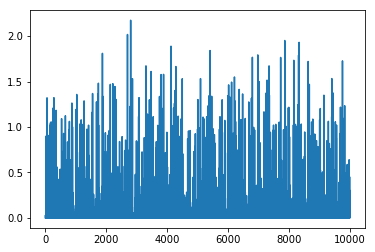

In [41]:
result_info['1'] = info_arr.cpu().numpy()
plt.plot(info_arr.cpu())
plt.show()

## 正常模型 - 对抗样本

In [42]:
epsilon = 0.3
criterion = nn.CrossEntropyLoss()
fgsm = FGSM(model, criterion, epsilon, DEVICE)

In [43]:
model.eval()

test_loss = 0
correct = 0
count = 0

info_arr = torch.tensor([])
info_arr = info_arr.to(DEVICE)

for data, target in test_loader:
    data, target = data.to(DEVICE), target.to(DEVICE)
    # 生成对抗样本
    data, sign = fgsm(data, target)
    output = model(data)

    test_loss += torch.nn.functional.cross_entropy(output, target, reduction='sum')
    pred = output.argmax(dim=1, keepdim=True)

    # 计算信息熵
#         tmp_sum = output.sum(dim=1, keepdim=True)
#         tmp_output = output / tmp_sum
    tmp_output = torch.softmax(output, dim=1)
    info_entropy = -tmp_output * torch.log2(tmp_output)
    info_entropy = info_entropy.sum(dim=1)

    info_arr = torch.cat((info_arr, info_entropy))
    correct += pred.eq(target.view_as(pred)).sum().item()

    count += len(data)
    print('\r {}|{}'.format(count, len(test_loader.dataset)), end='')

test_loss /= len(test_loader.dataset)
    
print('\ntest loss: {%0.4f}' % test_loss)
print('correct: {%0.4f}' % (correct/len(test_loader.dataset)) )

 10000|10000
test loss: {0.9431}
correct: {0.7460}


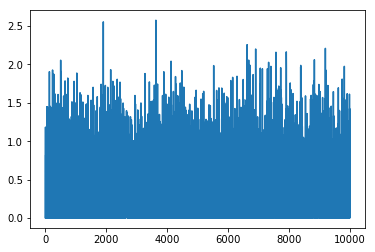

In [44]:
result_info['2'] = info_arr.detach().cpu().numpy()
plt.plot(info_arr.detach().cpu().numpy())
plt.show()

# 对抗训练的模型

## 对抗模型 - 干净样本

In [45]:
# 读取模型
if NORMALIZE:
    model_path = './model/LeNet_MNIST_adv.pt'
else:
    model_path = './model/LeNet_MNIST_unNormalize_adv.pt'

model_adv = LeNet()
model_adv.load_state_dict(torch.load(model_path))
print('read model: {}'.format(model_path))
model_adv = model_adv.to(DEVICE)

read model: ./model/LeNet_MNIST_adv.pt


In [46]:
# 对抗训练的准确率 和 信息熵

model_adv.eval()

test_loss = 0
correct = 0
count = 0

info_arr = torch.tensor([])
info_arr = info_arr.to(DEVICE)
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(DEVICE), target.to(DEVICE)
        output = model_adv(data)
        
        test_loss += torch.nn.functional.cross_entropy(output, target, reduction='sum')
        pred = output.argmax(dim=1, keepdim=True)
        
        # 计算信息熵
#         tmp_sum = output.sum(dim=1, keepdim=True)
#         tmp_output = output / tmp_sum
        tmp_output = torch.softmax(output, dim=1)
        info_entropy = -tmp_output * torch.log2(tmp_output)
        info_entropy = info_entropy.sum(dim=1)
        
        info_arr = torch.cat((info_arr, info_entropy))
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        count += len(data)
        print('\r {}|{}'.format(count, len(test_loader.dataset)), end='')
    
    test_loss /= len(test_loader.dataset)
    
print('\ntest loss: {%0.4f}' % test_loss)
print('correct: {%0.4f}' % (correct/len(test_loader.dataset)) )

 10000|10000
test loss: {0.0453}
correct: {0.9843}


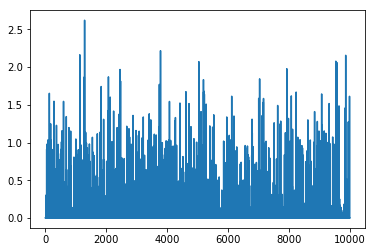

In [47]:
result_info['3'] = info_arr.cpu().numpy()
plt.plot(info_arr.cpu())
plt.show()

## 对抗模型 - 对抗样本

In [48]:
# 读取模型
if NORMALIZE:
    model_path = './model/LeNet_MNIST_adv.pt'
else:
    model_path = './model/LeNet_MNIST_unNormalize_adv.pt'

model_adv = LeNet()
model_adv.load_state_dict(torch.load(model_path))
print('read model: {}'.format(model_path))
model_adv = model_adv.to(DEVICE)

read model: ./model/LeNet_MNIST_adv.pt


In [49]:
##############################
# 注意，这里的对抗样本应该由哪个模型产生呢？
# model or model_adv ???
##############################
# 读取模型
if NORMALIZE:
    model_path = './model/LeNet_MNIST.pt'
else:
    model_path = './model/LeNet_MNIST_unNormalize.pt'
model = LeNet()
model.load_state_dict(torch.load(model_path))
model = model.to(DEVICE)

epsilon = 0.3
criterion = nn.CrossEntropyLoss()
fgsm = FGSM(model, criterion, epsilon, DEVICE)

In [50]:
# 对抗训练的准确率 和 信息熵

model_adv.eval()

test_loss = 0
correct = 0
count = 0

info_arr = torch.tensor([])
info_arr = info_arr.to(DEVICE)

for data, target in test_loader:
    data, target = data.to(DEVICE), target.to(DEVICE)
    data, sign = fgsm(data, target)

    output = model_adv(data)

    test_loss += torch.nn.functional.cross_entropy(output, target, reduction='sum')
    pred = output.argmax(dim=1, keepdim=True)
    correct += pred.eq(target.view_as(pred)).sum().item()
    
    # 计算信息熵
#         tmp_sum = output.sum(dim=1, keepdim=True)
#         tmp_output = output / tmp_sum
    tmp_output = torch.softmax(output, dim=1)
    info_entropy = -tmp_output * torch.log2(tmp_output)
    info_entropy = info_entropy.sum(dim=1)

    info_arr = torch.cat((info_arr, info_entropy))
    

    count += len(data)
    print('\r {}|{}'.format(count, len(test_loader.dataset)), end='')

test_loss /= len(test_loader.dataset)
    
print('\ntest loss: {%0.4f}' % test_loss)
print('correct: {%0.4f}' % (correct/len(test_loader.dataset)) )

 10000|10000
test loss: {0.0394}
correct: {0.9866}


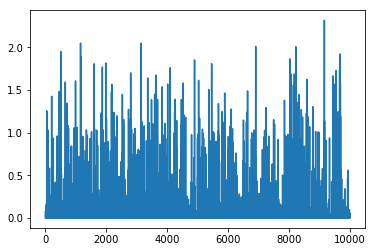

In [51]:
result_info['4'] = info_arr.detach().cpu().numpy()
plt.plot(info_arr.detach().cpu().numpy())
plt.show()

# 结果

In [52]:
print(key_info)
result_info

{'1': 'model - clean', '2': 'model - advExam', '3': 'modelAdv - clean', '4': 'modelAdv - advExam'}


{'1': array([  1.53575111e-05,   3.03104296e-02,   7.70997140e-04, ...,
          6.98039774e-04,   1.08967224e-05,   1.07149142e-04], dtype=float32),
 '2': array([  4.13051857e-05,   3.27620566e-01,   1.12423420e+00, ...,
          5.18477201e-01,   1.37626958e+00,   2.60543567e-03], dtype=float32),
 '3': array([  1.19557781e-05,   7.12358451e-04,   5.42644470e-04, ...,
          1.25847582e-03,   3.19727184e-03,   1.30401939e-04], dtype=float32),
 '4': array([  4.61627169e-05,   3.07442970e-04,   4.78032707e-05, ...,
          2.31567072e-03,   5.77406250e-02,   2.64643197e-04], dtype=float32)}

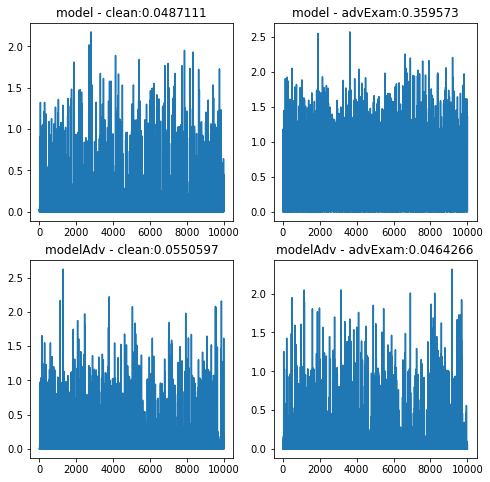

In [60]:
plt.figure(figsize=(8,8))

plt.subplot(2,2,1)
plt.plot(result_info['1'])
plt.title(key_info['1']+':'+ str(np.mean(result_info['1'])))


plt.subplot(2,2,2)
plt.plot(result_info['2'])
plt.title(key_info['2']+':'+ str(np.mean(result_info['2'])))


plt.subplot(2,2,3)
plt.plot(result_info['3'])
plt.title(key_info['3']+':'+ str(np.mean(result_info['3'])))


plt.subplot(2,2,4)
plt.plot(result_info['4'])
plt.title(key_info['4']+':'+ str(np.mean(result_info['4'])))
plt.show()

## 分析

**从熵的角度理解对抗训练对模型的影响：**

1. 比较左上角和右上角这两个图，发现以对抗样本为输入，正常模型的输出的熵要比较高，这说明正常模型对对样样本不比较不“自信的”，即反映出正常模型容易搜到对抗样本的攻击；
2. 比较左上角与左下角这两个图，发现正常模型经过对抗训练后，以正常样本为输入，正常模型的输出的熵值略微上升，说明正常模型经过对抗训练后，model_adv在正常样本上的性能是有所下降的；
3. 比较左下角和右下角这两个图，发现以对抗样本为输入，model_adv也能保持比较低的信息熵值，这表明model_adv确实能抵抗对抗样本的攻击。

In [71]:
a = np.array([0.5 ,0.5])

print((-a *np.log2(a)).sum())

1.0


# 拓展

**假设对抗样本来自model_adv，不是model会发生什么**

In [73]:
# 读取模型
if NORMALIZE:
    model_path = './model/LeNet_MNIST_adv.pt'
else:
    model_path = './model/LeNet_MNIST_unNormalize_adv.pt'

model_adv = LeNet()
model_adv.load_state_dict(torch.load(model_path))
print('read model: {}'.format(model_path))
model_adv = model_adv.to(DEVICE)

read model: ./model/LeNet_MNIST_adv.pt


In [74]:
##############################
# 注意，这里的对抗样本应该由哪个模型产生呢？
# model or model_adv ???
##############################
epsilon = 0.3
criterion = nn.CrossEntropyLoss()
fgsm = FGSM(model_adv, criterion, epsilon, DEVICE)

In [75]:
# 对抗训练的准确率 和 信息熵

model_adv.eval()

test_loss = 0
correct = 0
count = 0

info_arr = torch.tensor([])
info_arr = info_arr.to(DEVICE)

for data, target in test_loader:
    data, target = data.to(DEVICE), target.to(DEVICE)
    data, sign = fgsm(data, target)

    output = model_adv(data)

    test_loss += torch.nn.functional.cross_entropy(output, target, reduction='sum')
    pred = output.argmax(dim=1, keepdim=True)
    correct += pred.eq(target.view_as(pred)).sum().item()
    
    # 计算信息熵
#         tmp_sum = output.sum(dim=1, keepdim=True)
#         tmp_output = output / tmp_sum
    tmp_output = torch.softmax(output, dim=1)
    info_entropy = -tmp_output * torch.log2(tmp_output)
    info_entropy = info_entropy.sum(dim=1)

    info_arr = torch.cat((info_arr, info_entropy))
    

    count += len(data)
    print('\r {}|{}'.format(count, len(test_loader.dataset)), end='')

test_loss /= len(test_loader.dataset)
    
print('\ntest loss: {%0.4f}' % test_loss)
print('correct: {%0.4f}' % (correct/len(test_loader.dataset)) )

 10000|10000
test loss: {3.8901}
correct: {0.3486}


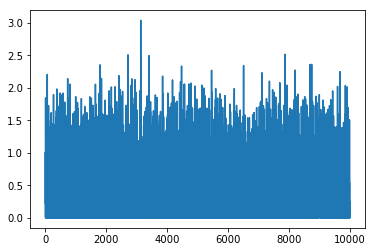

In [76]:
result_info['5'] = info_arr.detach().cpu().numpy()
plt.plot(info_arr.detach().cpu().numpy())
plt.show()

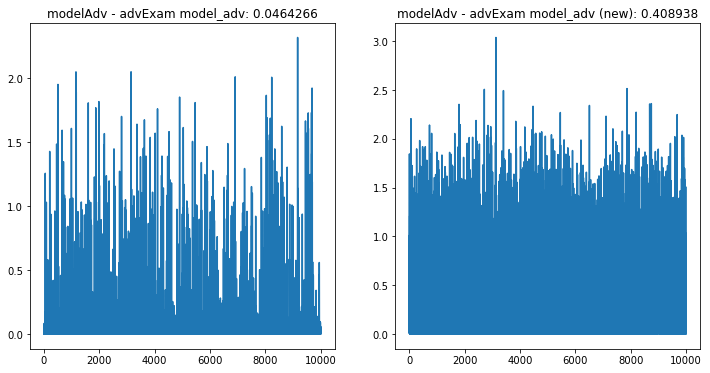

In [91]:
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.plot(result_info['4'])
plt.title(key_info['4']+' model_adv: '+ str(np.mean(result_info['4'])))

plt.subplot(1,2,2)
plt.plot(result_info['5'])
plt.title(key_info['4']+' model_adv (new): '+ str(np.mean(result_info['5'])))

plt.show()

In [93]:
np.log2(10)

3.3219280948873622